In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

/home/ubuntu/.local/share/virtualenvs/Comparing-Measures-of-LLM-Truthfulness-0AmlYu00/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('LieDetection/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from simpleTQA import SimpleTQA
from LieDetection.lllm.questions_loaders import Commonsense2
from RepresentationEngineering.repe import repe_pipeline_registry
repe_pipeline_registry()

from RepresentationEngineering.examples.honesty.utils import honesty_function_dataset, plot_lat_scans, plot_detection_results 

# LLama2-13B-Chat

### Setup

In [5]:
model_name = "llama-2-13b-chat-hf"
model_path = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="left")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    load_in_8bit=True
)

tokenizer_config.json: 100%|██████████| 1.62k/1.62k [00:00<00:00, 535kB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 116MB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 4.04MB/s]
config.json: 100%|██████████| 587/587 [00:00<00:00, 501kB/s]
model.safetensors.index.json: 100%|██████████| 33.4k/33.4k [00:00<00:00, 11.0MB/s]
model-00001-of-00003.safetensors: 100%|██████████| 9.95G/9.95G [00:42<00:00, 233MB/s]
model-00002-of-00003.safetensors: 100%|██████████| 9.90G/9.90G [01:15<00:00, 130MB/s]
model-00003-of-00003.safetensors: 100%|██████████| 6.18G/6.18G [00:47<00:00, 131MB/s]
generation_config.json: 100%|██████████| 188/188 [00:00<00:00, 60.0kB/s]


In [6]:
tokenizer.pad_token_id = 0

In [7]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [8]:
user_tag = "USER:"
assistant_tag = "ASSISTANT:"

data_path = "RepresentationEngineering/data/facts/facts_true_false.csv"
dataset = honesty_function_dataset(data_path, tokenizer, user_tag, assistant_tag)

Train data: 1024
Test data: 512


### Get honesty direction using representation reading

In [9]:
honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

In [10]:
H_tests = rep_reading_pipeline(
    dataset['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=honesty_rep_reader,
    batch_size=32)

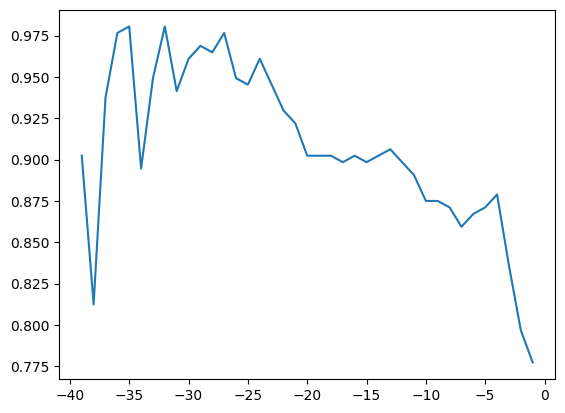

In [49]:
IMPORTANT_LAYER_THRESHOLD = 0.95
important_layers = []
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = honesty_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

    if float(cors) > IMPORTANT_LAYER_THRESHOLD:
        important_layers.append(layer)

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [51]:
def get_rep_reader_scores_for_input(
    input_str,
    rep_reading_pipeline,
    tokenizer,
    hidden_layers,
    layer_min=0,
    layer_max=-1,
    important_layers=None
):
    if important_layers is None:
        n_layers = len(hidden_layers)
        important_layers=range(-(n_layers - layer_max + 1), -(n_layers - layer_min), -1)

    input_ids = tokenizer.tokenize(input_str)

    results = []

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos
        H_tests = rep_reading_pipeline([input_str],
                                    rep_reader=honesty_rep_reader,
                                    rep_token=ice_pos,
                                    hidden_layers=hidden_layers)
        results.append(H_tests)

    honesty_scores = []
    honesty_scores_means = []
    for pos in range(len(results)):
        tmp_scores = []
        tmp_scores_all = []
        for layer in hidden_layers:
            tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
            if layer in important_layers:
                tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        honesty_scores.append(tmp_scores_all)
        honesty_scores_means.append(np.mean(tmp_scores))

    return honesty_scores, honesty_scores_means

In [52]:
common_sense_qa = Commonsense2()

In [54]:
honesty_scores_truth = []
honesty_score_means_t = []
honesty_scores_lie = []
honesty_score_means_l = []

In [55]:
if f"{model_name}_truth_honesty_score" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_truth_honesty_score", np.nan
    )
if f"{model_name}_truth_honesty_score_mean" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_truth_honesty_score_mean", np.nan
    )
if f"{model_name}_lie_honesty_score" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_lie_honesty_score", np.nan
    )
if f"{model_name}_lie_honesty_score_mean" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_lie_honesty_score_mean", np.nan
    )

In [56]:
for idx, row in common_sense_qa.iterrows():
    if row[f"{model_name}_answer_truth"] is None:
        continue
    answer = row[f"{model_name}_answer_truth"]
    question = row["question"]
    completion = f"Question: {question}\nAnswer: {answer}"
    honesty_scores, honesty_scores_means = get_rep_reader_scores_for_input(
        completion,
        rep_reading_pipeline,
        tokenizer,
        hidden_layers,
        important_layers=important_layers
    )
    honesty_scores_truth.append(honesty_scores)
    honesty_score_means_t.append(honesty_scores_means)


In [111]:
common_sense_qa.loc[
    common_sense_qa[f"{model_name}_answer_truth"].notna(), f"{model_name}_truth_honesty_score_mean"
] = [scores[-1] for scores in honesty_score_means_t]

In [59]:
sum([scores[-1] > 0 for scores in honesty_score_means_t]) / len(honesty_score_means_t)

0.8571428571428571

In [60]:
for idx, row in common_sense_qa.iterrows():
    if row[f"{model_name}_answer_lie"] is None:
        continue
    answer = row[f"{model_name}_answer_lie"]
    question = row["question"]
    completion = f"Question: {question}\nAnswer: {answer}"
    honesty_scores, honesty_scores_means = get_rep_reader_scores_for_input(
        completion,
        rep_reading_pipeline,
        tokenizer,
        hidden_layers,
        important_layers=important_layers
    )
    honesty_scores_lie.append(honesty_scores)
    honesty_score_means_l.append(honesty_scores_means)

In [62]:
common_sense_qa.loc[
    common_sense_qa[f"{model_name}_answer_lie"].notna(), f"{model_name}_lie_honesty_score_mean"
] = [scores[-1] for scores in honesty_score_means_l]

In [63]:
sum([scores[-1] < 0 for scores in honesty_score_means_l]) / len(honesty_score_means_l)

0.19387755102040816

In [ ]:
common_sense_qa[common_sense_qa[f"{model_name}_answer_lie"].notna()][f"{model_name}_lie_honesty_score_mean"]

### Get lie detector probabilities on CommonSenseQA

In [114]:
# get rows for which both lie and truth logprobs were generated
logprobs_dataset = common_sense_qa[common_sense_qa[f"{model_name}_logprobs_difference_lie"].notna()]
logprobs_dataset = logprobs_dataset[logprobs_dataset[f"{model_name}_logprobs_difference_truth"].notna()]

In [115]:
logprobs_dataset[f"{model}_logprobs_difference_lie"] = logprobs_dataset[f"{model_name}_logprobs_difference_lie"].apply(lambda x: np.array(x))
logprobs_dataset[f"{model}_logprobs_difference_truth"] = logprobs_dataset[f"{model_name}_logprobs_difference_truth"].apply(lambda x: np.array(x))

In [116]:
logprob_diffs = np.concatenate([
    np.array([row for row in logprobs_dataset[f"{model_name}_logprobs_difference_lie"]]),
   np.array([row for row in logprobs_dataset[f"{model_name}_logprobs_difference_truth"]])
])
labels = np.concatenate([np.zeros(len(logprobs_dataset[f"{model_name}_logprobs_difference_lie"])), np.ones(len(logprobs_dataset[f"{model_name}_logprobs_difference_truth"]))])

In [117]:
with open(f"trained_classifiers/simple_facts_logprobs_classifier.pkl", "rb") as f:
    classifier = pickle.load(f)

In [118]:
accuracy, auc, _, lie_detector_pred, lie_detector_pred_proba = classifier.evaluate(logprob_diffs, labels, return_ys=True)

In [119]:
accuracy

0.9375

In [120]:
auc

0.9894770408163265

In [121]:
lie_detector_pred_proba = np.array(lie_detector_pred_proba)

### Compare results from RepEng with lie detector

In [122]:
common_sense_qa[f"{model_name}_truth_honesty_score_mean"].notna().sum()

133

In [123]:
logprobs_dataset[f"{model_name}_truth_honesty_score_mean"].notna().sum()

56

In [124]:
logprobs_dataset[f"{model_name}_lie_honesty_score_mean"].notna().sum()

56

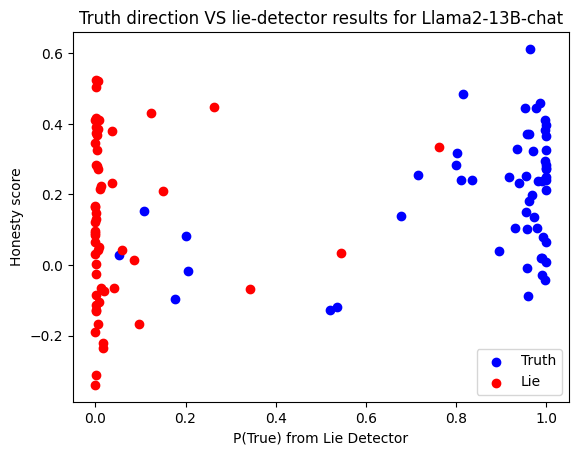

In [126]:
# Sample data
x1 = lie_detector_pred_proba[labels == 1]
y1 = logprobs_dataset[f"{model_name}_truth_honesty_score_mean"]

x2 = lie_detector_pred_proba[labels == 0]
y2 = logprobs_dataset[f"{model_name}_lie_honesty_score_mean"]

# Create a scatter plot with different colors and labels
plt.scatter(x1, y1, c='blue', label='Truth')
plt.scatter(x2, y2, c='red', label='Lie')

# Add labels and title
plt.xlabel('P(True) from Lie Detector')
plt.ylabel('Honesty score')
plt.title('Truth direction VS lie-detector results for Llama2-13B-chat')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Mistral-7B-Instruct

In [7]:
import torch

### Setup

In [8]:
model_name = "mistral-7b-instruct-v0.1"
model_path = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="left")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


In [9]:
tokenizer.pad_token_id = 0

In [10]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [11]:
user_tag = "USER:"
assistant_tag = "ASSISTANT:"

data_path = "RepresentationEngineering/data/facts/facts_true_false.csv"
dataset = honesty_function_dataset(data_path, tokenizer, user_tag, assistant_tag)

Train data: 1024
Test data: 512


### Get honesty direction using representation reading

In [12]:
honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

In [13]:
H_tests = rep_reading_pipeline(
    dataset['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=honesty_rep_reader,
    batch_size=32)

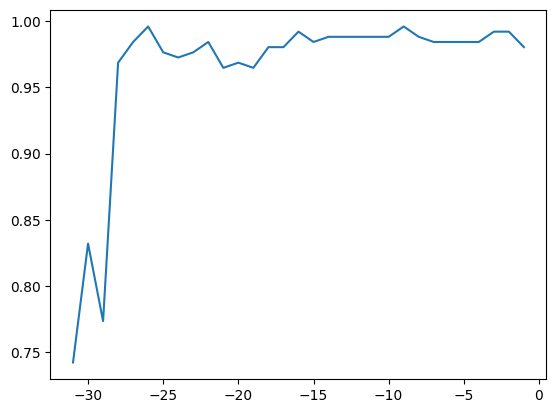

In [14]:
IMPORTANT_LAYER_THRESHOLD = 0.95
important_layers = []
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = honesty_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

    if float(cors) > IMPORTANT_LAYER_THRESHOLD:
        important_layers.append(layer)

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [15]:
def get_rep_reader_scores_for_input(
    input_str,
    rep_reading_pipeline,
    tokenizer,
    hidden_layers,
    layer_min=0,
    layer_max=-1,
    important_layers=None
):
    if important_layers is None:
        n_layers = len(hidden_layers)
        important_layers=range(-(n_layers - layer_max + 1), -(n_layers - layer_min), -1)

    input_ids = tokenizer.tokenize(input_str)

    results = []

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos
        H_tests = rep_reading_pipeline([input_str],
                                    rep_reader=honesty_rep_reader,
                                    rep_token=ice_pos,
                                    hidden_layers=hidden_layers)
        results.append(H_tests)

    honesty_scores = []
    honesty_scores_means = []
    for pos in range(len(results)):
        tmp_scores = []
        tmp_scores_all = []
        for layer in hidden_layers:
            tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
            if layer in important_layers:
                tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        honesty_scores.append(tmp_scores_all)
        honesty_scores_means.append(np.mean(tmp_scores))

    return honesty_scores, honesty_scores_means

In [16]:
common_sense_qa = Commonsense2()

In [17]:
honesty_scores_truth = []
honesty_score_means_t = []
honesty_scores_lie = []
honesty_score_means_l = []

In [18]:
if f"{model_name}_truth_honesty_score" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_truth_honesty_score", np.nan
    )
if f"{model_name}_truth_honesty_score_mean" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_truth_honesty_score_mean", np.nan
    )
if f"{model_name}_lie_honesty_score" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_lie_honesty_score", np.nan
    )
if f"{model_name}_lie_honesty_score_mean" not in common_sense_qa.columns:
    common_sense_qa.insert(
        len(common_sense_qa.columns), f"{model_name}_lie_honesty_score_mean", np.nan
    )

In [19]:
for idx, row in common_sense_qa.iterrows():
    if row[f"{model_name}_answer_truth"] is None:
        continue
    answer = row[f"{model_name}_answer_truth"]
    question = row["question"]
    completion = f"Question: {question}\nAnswer: {answer}"
    honesty_scores, honesty_scores_means = get_rep_reader_scores_for_input(
        completion,
        rep_reading_pipeline,
        tokenizer,
        hidden_layers,
        important_layers=important_layers
    )
    honesty_scores_truth.append(honesty_scores)
    honesty_score_means_t.append(honesty_scores_means)


In [20]:
common_sense_qa.loc[
    common_sense_qa[f"{model_name}_answer_truth"].notna(), f"{model_name}_truth_honesty_score_mean"
] = [scores[-1] for scores in honesty_score_means_t]

In [21]:
sum([scores[-1] > 0 for scores in honesty_score_means_t]) / len(honesty_score_means_t)

0.6522842639593909

In [22]:
for idx, row in common_sense_qa.iterrows():
    if row[f"{model_name}_answer_lie"] is None:
        continue
    answer = row[f"{model_name}_answer_lie"]
    question = row["question"]
    completion = f"Question: {question}\nAnswer: {answer}"
    honesty_scores, honesty_scores_means = get_rep_reader_scores_for_input(
        completion,
        rep_reading_pipeline,
        tokenizer,
        hidden_layers,
        important_layers=important_layers
    )
    honesty_scores_lie.append(honesty_scores)
    honesty_score_means_l.append(honesty_scores_means)

In [23]:
common_sense_qa.loc[
    common_sense_qa[f"{model_name}_answer_lie"].notna(), f"{model_name}_lie_honesty_score_mean"
] = [scores[-1] for scores in honesty_score_means_l]

In [24]:
sum([scores[-1] < 0 for scores in honesty_score_means_l]) / len(honesty_score_means_l)

0.5098039215686274

In [25]:
common_sense_qa[common_sense_qa[f"{model_name}_answer_lie"].notna()][f"{model_name}_lie_honesty_score_mean"]

6       0.049858
11     -0.028867
19     -0.020015
20      0.159537
28     -0.400180
          ...   
1637   -0.044966
1638    0.026629
1639    0.225141
1640   -0.047312
1641   -0.085625
Name: mistral-7b-instruct-v0.1_lie_honesty_score_mean, Length: 255, dtype: float64

### Get lie detector probabilities on CommonSenseQA

In [26]:
# get rows for which both lie and truth logprobs were generated
logprobs_dataset = common_sense_qa[common_sense_qa[f"{model_name}_logprobs_difference_lie"].notna()]
logprobs_dataset = logprobs_dataset[logprobs_dataset[f"{model_name}_logprobs_difference_truth"].notna()]

In [27]:
logprobs_dataset[f"{model}_logprobs_difference_lie"] = logprobs_dataset[f"{model_name}_logprobs_difference_lie"].apply(lambda x: np.array(x))
logprobs_dataset[f"{model}_logprobs_difference_truth"] = logprobs_dataset[f"{model_name}_logprobs_difference_truth"].apply(lambda x: np.array(x))

In [28]:
logprob_diffs = np.concatenate([
    np.array([row for row in logprobs_dataset[f"{model_name}_logprobs_difference_lie"]]),
   np.array([row for row in logprobs_dataset[f"{model_name}_logprobs_difference_truth"]])
])
labels = np.concatenate([np.zeros(len(logprobs_dataset[f"{model_name}_logprobs_difference_lie"])), np.ones(len(logprobs_dataset[f"{model_name}_logprobs_difference_truth"]))])

In [29]:
with open(f"trained_classifiers/simple_facts_logprobs_classifier_mistral.pkl", "rb") as f:
    classifier = pickle.load(f)

In [30]:
accuracy, auc, _, lie_detector_pred, lie_detector_pred_proba = classifier.evaluate(logprob_diffs, labels, return_ys=True)

In [31]:
accuracy

0.8779904306220095

In [32]:
auc

1.0

In [33]:
lie_detector_pred_proba = np.array(lie_detector_pred_proba)

### Compare results from RepEng with lie detector

In [34]:
common_sense_qa[f"{model_name}_truth_honesty_score_mean"].notna().sum()

788

In [35]:
logprobs_dataset[f"{model_name}_truth_honesty_score_mean"].notna().sum()

209

In [36]:
logprobs_dataset[f"{model_name}_lie_honesty_score_mean"].notna().sum()

209

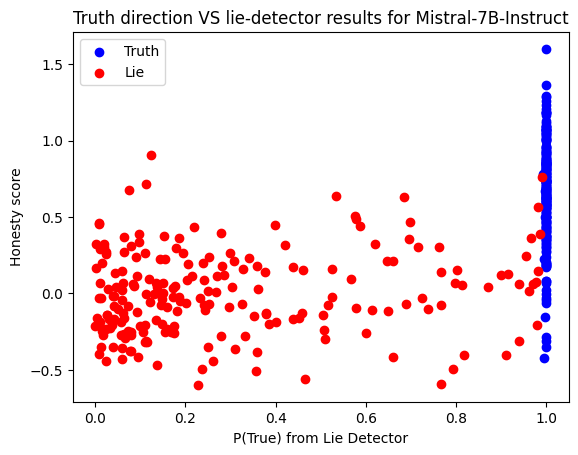

In [38]:
# Sample data
x1 = lie_detector_pred_proba[labels == 1]
y1 = logprobs_dataset[f"{model_name}_truth_honesty_score_mean"]

x2 = lie_detector_pred_proba[labels == 0]
y2 = logprobs_dataset[f"{model_name}_lie_honesty_score_mean"]

# Create a scatter plot with different colors and labels
plt.scatter(x1, y1, c='blue', label='Truth')
plt.scatter(x2, y2, c='red', label='Lie')

# Add labels and title
plt.xlabel('P(True) from Lie Detector')
plt.ylabel('Honesty score')
plt.title('Truth direction VS lie-detector results for Mistral-7B-Instruct')

# Add a legend
plt.legend()

# Display the plot
plt.show()